In [2]:
#from google.colab import drive

# Mount your Google Drive
#drive.mount('/content/drive')

## Imports

In [1]:
import pandas as pd
import numpy as np

# Install RDKit
#!pip install rdkit-pypi
#!pip install --upgrade rdkit-pypi pandas

from rdkit import Chem
from rdkit.Chem import PandasTools
from rdkit.Chem import Draw

# import pickle
import pickle

# install torch geometric
#!pip install torch torchvision torchaudio
#!pip install torch-geometric torch-scatter torch-sparse torch-cluster torch-spline-conv

import torch
import torch_geometric
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv, GINConv, MessagePassing, global_mean_pool
from torch_geometric.nn.models import GIN
from torch_geometric.loader import DataLoader
import torch.nn as nn
from torch.nn import Sequential, Linear, ReLU, Dropout
import torch.nn.functional as F
from torch.optim import Adam

#!pip install nfp
#from nfp.preprocessing import MolPreprocessor
from nfp.preprocessing import features
from nfp.preprocessing import Tokenizer
from tqdm import tqdm
import time

Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
C:\Users\drjac\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
C:\Users\drjac\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:97: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-cluster'. "
C:\Users\drjac\AppData\Roaming\Python\Python311\site-packages\torch_geometric\typing.py:113: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure c

## file load

In [8]:
# File paths
#test_path = '/content/drive/MyDrive/CSC461/test.pkl.gz'
#valid_path = '/content/drive/MyDrive/CSC461/valid.pkl.gz'
#train_path = '/content/drive/MyDrive/CSC461/train.pkl.gz'

# file paths on pc
test_path = 'C:/Users/drjac/OneDrive/CSC461/data/test.pkl.gz'
valid_path = 'C:/Users/drjac/OneDrive/CSC461/data/valid.pkl.gz'
train_path = 'C:/Users/drjac/OneDrive/CSC461/data/train.pkl.gz'

# Read the gzip-compressed pickle files
test_df = pd.read_pickle(test_path, compression='gzip')
valid_df = pd.read_pickle(valid_path, compression='gzip')
train_df = pd.read_pickle(train_path, compression='gzip')

# Display the DataFrames
print("Test DataFrame:")
print(test_df.head())
print("\nValidation DataFrame:")
print(valid_df.head())
print("\nTraining DataFrame:")
print(train_df.head())
test_df.head()


Test DataFrame:
                                                        Mol  Atom_number  \
mol_id                                                                     
10021715  <rdkit.Chem.rdchem.Mol object at 0x00000218075...           48   
20208812  <rdkit.Chem.rdchem.Mol object at 0x00000218075...           27   
20031163  <rdkit.Chem.rdchem.Mol object at 0x00000218075...           27   
20165625  <rdkit.Chem.rdchem.Mol object at 0x00000218075...           57   
10018474  <rdkit.Chem.rdchem.Mol object at 0x00000218075...           40   

                                                 atom_index  \
mol_id                                                        
10021715  [23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...   
20208812   [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]   
20031163  [11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...   
20165625  [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...   
10018474  [16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...   

         

,Mol,Atom_number,atom_index,Shift
mol_id,,,,
10021715,<rdkit.Chem.rdchem.Mol object at 0x00000218075...,48,"[23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 3...","[7.4083204, 3.263883, 7.440789, 7.0217943, 7.2..."
20208812,<rdkit.Chem.rdchem.Mol object at 0x00000218075...,27,"[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26]","[7.723068, 7.723889, 4.0092998, 4.075241, 4.00..."
20031163,<rdkit.Chem.rdchem.Mol object at 0x00000218075...,27,"[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 2...","[1.2216252, 1.0022777, 0.9024084, 2.620798, 2...."
20165625,<rdkit.Chem.rdchem.Mol object at 0x00000218075...,57,"[33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 4...","[5.102754, 6.544702, 6.9713583, 6.309941, 6.86..."
10018474,<rdkit.Chem.rdchem.Mol object at 0x00000218075...,40,"[16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 2...","[1.3406475, 0.9988119, 1.8741956, 1.0424078, 1..."


In [9]:
y_train = train_df.Shift.values
y_test = test_df.Shift.values
y_val = valid_df.Shift.values
y_train[0]

array([ 6.2862277,  1.8515768,  3.06077  ,  1.8287755,  2.1147938,
        1.9405926,  2.4125774,  5.2048125,  1.7113038,  1.9827293,
        1.6478252,  5.1483564,  9.646486 ,  6.1986713,  2.1315756,
        2.0812304,  2.3436267,  1.7480594,  2.5291371,  1.9526317,
        5.372994 ,  1.7547172,  1.7854533,  2.181191 , 11.188395 ,
        6.192834 ], dtype=float32)

## Classes from CASCADE paper

In [2]:

def atomic_number_tokenizer(atom):
    return atom.GetAtomicNum()
def Mol_iter(df):
    for index,r in df.iterrows():
        yield(r['Mol'], r['atom_index'])

class SmilesPreprocessor(object):
    """ Given a list of SMILES strings, encode these molecules as atom and
    connectivity feature matricies.

    Example:
    >>> preprocessor = SmilesPreprocessor(explicit_hs=False)
    >>> inputs = preprocessor.fit(data.smiles)
    """

    def __init__(self, explicit_hs=True, atom_features=None, bond_features=None):
        """

        explicit_hs : bool
            whether to tell RDkit to add H's to a molecule.
        atom_features : function
            A function applied to an rdkit.Atom that returns some
            representation (i.e., string, integer) for the Tokenizer class.
        bond_features : function
            A function applied to an rdkit Bond to return some description.

        """

        self.atom_tokenizer = Tokenizer()
        self.bond_tokenizer = Tokenizer()
        self.explicit_hs = explicit_hs

        if atom_features is None:
            atom_features = features.atom_features_v1

        if bond_features is None:
            bond_features = features.bond_features_v1

        self.atom_features = atom_features
        self.bond_features = bond_features


    def fit(self, smiles_iterator):
        """ Fit an iterator of SMILES strings, creating new atom and bond
        tokens for unseen molecules. Returns a dictionary with 'atom' and
        'connectivity' entries """
        return list(self.preprocess(smiles_iterator, train=True))


    def predict(self, smiles_iterator):
        """ Uses previously determined atom and bond tokens to convert a SMILES
        iterator into 'atom' and 'connectivity' matrices. Ensures that atom and
        bond classes commute with previously determined results. """
        return list(self.preprocess(smiles_iterator, train=False))


    def preprocess(self, smiles_iterator, train=True):

        self.atom_tokenizer.train = train
        self.bond_tokenizer.train = train

        for smiles in tqdm(smiles_iterator):
            yield self.construct_feature_matrices(smiles)


    @property
    def atom_classes(self):
        """ The number of atom types found (includes the 0 null-atom type) """
        return self.atom_tokenizer.num_classes + 1


    @property
    def bond_classes(self):
        """ The number of bond types found (includes the 0 null-bond type) """
        return self.bond_tokenizer.num_classes + 1


    def construct_feature_matrices(self, smiles):
        """ construct a molecule from the given smiles string and return atom
        and bond classes.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of bonds in the molecule
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        mol = MolFromSmiles(smiles)
        if self.explicit_hs:
            mol = AddHs(mol)

        n_atom = len(mol.GetAtoms())
        n_bond = 2 * len(mol.GetBonds())

        # If its an isolated atom, add a self-link
        if n_bond == 0:
            n_bond = 1

        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        bond_index = 0

        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        for n, atom in enumerate(atoms):

            # Atom Classes
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            start_index = atom.GetIdx()

            for bond in atom.GetBonds():
                # Is the bond pointing at the target atom
                rev = bond.GetBeginAtomIdx() != start_index

                # Bond Classes
                bond_feature_matrix[n] = self.bond_tokenizer(
                    self.bond_features(bond, flipped=rev))

                # Connectivity
                if not rev:  # Original direction
                    connectivity[bond_index, 0] = bond.GetBeginAtomIdx()
                    connectivity[bond_index, 1] = bond.GetEndAtomIdx()

                else:  # Reversed
                    connectivity[bond_index, 0] = bond.GetEndAtomIdx()
                    connectivity[bond_index, 1] = bond.GetBeginAtomIdx()

                bond_index += 1


        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'connectivity': connectivity,
        }

'''
class ConnectivityAPreprocessor(object):
    """ Given a list of SMILES strings, encode these molecules as atom and
    connectivity feature matricies.

    Example:
    >>> preprocessor = SmilesPreprocessor(explicit_hs=False)
    >>> inputs = preprocessor.fit(data.smiles)
    """

    def __init__(self, explicit_hs=True, atom_features=None, bond_features=None):
        """

        explicit_hs : bool
            whether to tell RDkit to add H's to a molecule.
        atom_features : function
            A function applied to an rdkit.Atom that returns some
            representation (i.e., string, integer) for the Tokenizer class.
        bond_features : function
            A function applied to an rdkit Bond to return some description.

        """

        self.atom_tokenizer = Tokenizer()
        self.bond_tokenizer = Tokenizer()
        self.explicit_hs = explicit_hs

        if atom_features is None:
            atom_features = features.atom_features_v1

        if bond_features is None:
            bond_features = features.bond_features_v1

        self.atom_features = atom_features
        self.bond_features = bond_features


    def fit(self, smiles_iterator):
        """ Fit an iterator of SMILES strings, creating new atom and bond
        tokens for unseen molecules. Returns a dictionary with 'atom' and
        'connectivity' entries """
        return list(self.preprocess(smiles_iterator, train=True))


    def predict(self, smiles_iterator):
        """ Uses previously determined atom and bond tokens to convert a SMILES
        iterator into 'atom' and 'connectivity' matrices. Ensures that atom and
        bond classes commute with previously determined results. """
        return list(self.preprocess(smiles_iterator, train=False))


    def preprocess(self, smiles_iterator, train=True):

        self.atom_tokenizer.train = train
        self.bond_tokenizer.train = train

        for smiles in tqdm(smiles_iterator):
            yield self.construct_feature_matrices(smiles)


    @property
    def atom_classes(self):
        """ The number of atom types found (includes the 0 null-atom type) """
        return self.atom_tokenizer.num_classes + 1


    @property
    def bond_classes(self):
        """ The number of bond types found (includes the 0 null-bond type) """
        return self.bond_tokenizer.num_classes + 1


    def construct_feature_matrices(self, smiles):
        """ construct a molecule from the given smiles string and return atom
        and bond classes.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of bonds in the molecule
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        mol = MolFromSmiles(smiles)
        if self.explicit_hs:
            mol = AddHs(mol)

        n_atom = len(mol.GetAtoms())
        n_bond = 2 * len(mol.GetBonds())

        # If its an isolated atom, add a self-link
        if n_bond == 0:
            n_bond = 1

        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        bond_index = 0

        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        for n, atom in enumerate(atoms):

            # Atom Classes
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            start_index = atom.GetIdx()

            for bond in atom.GetBonds():
                # Is the bond pointing at the target atom
                rev = bond.GetBeginAtomIdx() != start_index

                # Bond Classes
                bond_feature_matrix[n] = self.bond_tokenizer(
                    self.bond_features(bond, flipped=rev))

                # Connectivity
                if not rev:  # Original direction
                    connectivity[bond_index, 0] = bond.GetBeginAtomIdx()
                    connectivity[bond_index, 1] = bond.GetEndAtomIdx()

                else:  # Reversed
                    connectivity[bond_index, 0] = bond.GetEndAtomIdx()
                    connectivity[bond_index, 1] = bond.GetBeginAtomIdx()

                bond_index += 1

        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'connectivity': connectivity,
        }

'''
class MolPreprocessor(SmilesPreprocessor):
    """ I should refactor this into a base class and separate
    SmilesPreprocessor classes. But the idea is that we only need to redefine
    the `construct_feature_matrices` method to have a working preprocessor that
    handles 3D structures.

    We'll pass an iterator of mol objects instead of SMILES strings this time,
    though.

    """

    def __init__(self, n_neighbors, cutoff, **kwargs):
        """ A preprocessor class that also returns distances between
        neighboring atoms. Adds edges for non-bonded atoms to include a maximum
        of n_neighbors around each atom """

        self.n_neighbors = n_neighbors
        self.cutoff = cutoff
        super(MolPreprocessor, self).__init__(**kwargs)


    def construct_feature_matrices(self, mol):
        """ Given an rdkit mol, return atom feature matrices, bond feature
        matrices, and connectivity matrices.

        Returns
        dict with entries
        'n_atom' : number of atoms in the molecule
        'n_bond' : number of edges (likely n_atom * n_neighbors)
        'atom' : (n_atom,) length list of atom classes
        'bond' : (n_bond,) list of bond classes. 0 for no bond
        'distance' : (n_bond,) list of bond distances
        'connectivity' : (n_bond, 2) array of source atom, target atom pairs.

        """

        n_atom = len(mol.GetAtoms())

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        if self.n_neighbors <= (n_atom - 1):
            n_bond = self.n_neighbors * n_atom
        else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
            n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):

            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                if bond is None:
                    bond_feature_matrix[bond_index] = 0
                else:
                    rev = False if bond.GetBeginAtomIdx() == n else True
                    bond_feature_matrix[bond_index] = self.bond_tokenizer(
                        self.bond_features(bond, flipped=rev))

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        print(connectivity)

        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
        }

'''
class MolBPreprocessor(MolPreprocessor):
    """
    This is a subclass of Molpreprocessor that preprocessor molecule with
    bond property target
    """
    def __init__(self, **kwargs):
        """
        A preprocessor class that also returns bond_target_matrix, besides the bond matrix
        returned by MolPreprocessor. The bond_target_matrix is then used as ref to reduce molecule
        to bond property
        """
        super(MolBPreprocessor, self).__init__(**kwargs)

    def construct_feature_matrices(self, entry):
        """
        Given an entry contining rdkit molecule, bond_index and for the target property,
        return atom
        feature matrices, bond feature matrices, distance matrices, connectivity matrices and bond
        ref matrices.

        returns
        dict with entries
        see MolPreproccessor
        'bond_index' : ref array to the bond index
        """
        mol, bond_index_array = entry

        n_atom = len(mol.GetAtoms())
        n_pro = len(bond_index_array)

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        if self.n_neighbors <= (n_atom - 1):
            n_bond = self.n_neighbors * n_atom
        else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
            n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        bond_index_matrix = np.full(n_bond, -1, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):
            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))

            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                if bond is None:
                    bond_feature_matrix[bond_index] = 0
                else:
                    rev = False if bond.GetBeginAtomIdx() == n else True
                    bond_feature_matrix[bond_index] = self.bond_tokenizer(
                        self.bond_features(bond, flipped=rev))
                    try:
                        bond_index_matrix[bond_index] = bond_index_array.tolist().index(bond.GetIdx())
                    except:
                        pass

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'n_pro': n_pro,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
            'bond_index': bond_index_matrix,
        }
'''
class MolAPreprocessor(MolPreprocessor):
    """
    This is a subclass of Molpreprocessor that preprocessor molecule with
    bond property target
    """
    def __init__(self, **kwargs):
        """
        A preprocessor class that also returns bond_target_matrix, besides the bond matrix
        returned by MolPreprocessor. The bond_target_matrix is then used as ref to reduce molecule
        to bond property
        """
        super(MolAPreprocessor, self).__init__(**kwargs)

    def construct_feature_matrices(self, entry):
        """
        Given an entry contining rdkit molecule, bond_index and for the target property,
        return atom
        feature matrices, bond feature matrices, distance matrices, connectivity matrices and bond
        ref matrices.

        returns
        dict with entries
        see MolPreproccessor
        'bond_index' : ref array to the bond index
        """
        mol, atom_index_array = entry

        n_atom = len(mol.GetAtoms())
        n_pro = len(atom_index_array)

        # n_bond is actually the number of atom-atom pairs, so this is defined
        # by the number of neighbors for each atom.
        #if there is cutoff,
        distance_matrix = Chem.Get3DDistanceMatrix(mol)

        #if self.n_neighbors <= (n_atom - 1):
        #    n_bond = self.n_neighbors * n_atom
        #else:
            # If there are fewer atoms than n_neighbors, all atoms will be
            # connected
        n_bond = distance_matrix[(distance_matrix < self.cutoff) & (distance_matrix != 0)].size

        if n_bond == 0: n_bond = 1

        # Initialize the matrices to be filled in during the following loop.
        atom_feature_matrix = np.zeros(n_atom, dtype='int')
        bond_feature_matrix = np.zeros(n_bond, dtype='int')
        bond_distance_matrix = np.zeros(n_bond, dtype=np.float32)
        atom_index_matrix = np.full(n_atom, -1, dtype='int')
        connectivity = np.zeros((n_bond, 2), dtype='int')

        # Hopefully we've filtered out all problem mols by now.
        if mol is None:
            raise RuntimeError("Issue in loading mol")

        # Get a list of the atoms in the molecule.
        atom_seq = mol.GetAtoms()
        atoms = [atom_seq[i] for i in range(n_atom)]

        # Here we loop over each atom, and the inner loop iterates over each
        # neighbor of the current atom.
        bond_index = 0  # keep track of our current bond.
        for n, atom in enumerate(atoms):
            # update atom feature matrix
            atom_feature_matrix[n] = self.atom_tokenizer(
                self.atom_features(atom))
            try:
                atom_index_matrix[n] = atom_index_array.tolist().index(atom.GetIdx())
            except:
                pass
            # if n_neighbors is greater than total atoms, then each atom is a
            # neighbor.
            if (self.n_neighbors + 1) > len(mol.GetAtoms()):
                neighbor_end_index = len(mol.GetAtoms())
            else:
                neighbor_end_index = (self.n_neighbors + 1)

            distance_atom = distance_matrix[n, :]
            cutoff_end_index = distance_atom[distance_atom < self.cutoff].size

            end_index = min(neighbor_end_index, cutoff_end_index)

            # Loop over each of the nearest neighbors

            neighbor_inds = distance_matrix[n, :].argsort()[1:end_index]
            if len(neighbor_inds)==0: neighbor_inds = [n]
            for neighbor in neighbor_inds:

                # update bond feature matrix
                bond = mol.GetBondBetweenAtoms(n, int(neighbor))
                try:
                    if bond is None:
                        bond_feature_matrix[bond_index] = 0
                    else:
                        rev = False if bond.GetBeginAtomIdx() == n else True
                        bond_feature_matrix[bond_index] = self.bond_tokenizer(
                            self.bond_features(bond, flipped=rev))
                except:
                    print('AAAAAAAAAAAAAAA')
                    print(mol.GetProp('_Name'))
                    print(mol.GetProp('ConfId'))

                distance = distance_matrix[n, neighbor]
                bond_distance_matrix[bond_index] = distance

                # update connectivity matrix
                connectivity[bond_index, 0] = n
                connectivity[bond_index, 1] = neighbor

                bond_index += 1
        return {
            'n_atom': n_atom,
            'n_bond': n_bond,
            'n_pro': n_pro,
            'atom': atom_feature_matrix,
            'bond': bond_feature_matrix,
            'distance': bond_distance_matrix,
            'connectivity': connectivity,
            'atom_index': atom_index_matrix,
        }

## Read Data

In [10]:
# File path
#processed_inputs_path = '/content/drive/MyDrive/CSC461/processed_inputs.pkl'

# file path on pc
processed_inputs_path = 'C:/Users/drjac/OneDrive/CSC461/data/processed_inputs.pkl'

# Load the pickle file
with open(processed_inputs_path, 'rb') as file:
    processed_inputs = pickle.load(file)

# Access the elements in the dictionary
inputs_train = processed_inputs['inputs_train']
inputs_valid = processed_inputs['inputs_valid']
inputs_test = processed_inputs['inputs_test']
preprocessor = processed_inputs['preprocessor']

# Display the loaded objects
#print("Training Inputs:", inputs_train)
#print("\nValidation Inputs:", inputs_valid)
#print("\nTest Inputs:", inputs_test)
#print("\nPreprocessor:", preprocessor)

In [11]:
np.set_printoptions(threshold=np.inf)
inputs_train[0]

{'n_atom': 57,
 'n_bond': 1274,
 'n_pro': 26,
 'atom': array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 2, 3, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 2, 2, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64),
 'bond': array([2, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 3, 3, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        2, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 3, 3, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 6,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 7, 6, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 7, 5, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Further data processing

In [12]:
#'''
# Graph creation function with normalization
def create_graph(data, shifts, feature_mean=None, feature_std=None, target_min=None, target_max=None):
    """
    Constructs a PyTorch Geometric Data object for a graph, with optional normalization.

    Args:
    - data (dict): Dictionary containing graph data like 'connectivity', 'atom', and 'bond'.
    - shifts (list or np.array): Target values (chemical shifts) corresponding to each node.
    - feature_mean (torch.Tensor): Mean values for node features (optional for normalization).
    - feature_std (torch.Tensor): Standard deviation values for node features (optional for normalization).
    - target_min (float): Minimum value of targets (optional for normalization).
    - target_max (float): Maximum value of targets (optional for normalization).

    Returns:
    - Data: A PyTorch Geometric Data object.
    """
    edge_index = torch.tensor(data['connectivity'].T, dtype=torch.long)  # Shape: [2, num_edges]
    x = torch.tensor(data['atom'], dtype=torch.float).unsqueeze(1)  # Node features
    edge_attr = torch.tensor(data['bond'], dtype=torch.float).unsqueeze(1)  # Edge features

    # Normalize node features if mean and std are provided
    if feature_mean is not None and feature_std is not None:
        x = (x - feature_mean) / feature_std

    num_nodes = x.shape[0]
    
    # Convert shifts to a list for padding/truncation
    shifts = list(shifts)
    if len(shifts) > num_nodes:
        shifts = shifts[:num_nodes]  # Truncate to match the number of nodes
    elif len(shifts) < num_nodes:
        shifts.extend([0.0] * (num_nodes - len(shifts)))  # Pad with zeros to match the number of nodes

    y = torch.tensor(shifts, dtype=torch.float)  # Node-level chemical shifts (targets)

    # Normalize target values if min and max are provided
    if target_min is not None and target_max is not None:
        y = (y - target_min) / (target_max - target_min)

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Dataset preparation with normalization parameters
# Compute normalization parameters from training data
feature_tensor = torch.cat([torch.tensor(sample['atom'], dtype=torch.float) for sample in inputs_train]).unsqueeze(1)
feature_mean = feature_tensor.mean(dim=0)
feature_std = feature_tensor.std(dim=0)

target_tensor = torch.cat([torch.tensor(shifts, dtype=torch.float) for shifts in y_train])
target_min = target_tensor.min().item()
target_max = target_tensor.max().item()

# Normalize and create graphs for each dataset
train_graphs = [create_graph(sample, shifts, feature_mean, feature_std, target_min, target_max)
                for sample, shifts in zip(inputs_train, y_train)]
valid_graphs = [create_graph(sample, shifts, feature_mean, feature_std, target_min, target_max)
                for sample, shifts in zip(inputs_valid, y_val)]
test_graphs = [create_graph(sample, shifts, feature_mean, feature_std, target_min, target_max)
               for sample, shifts in zip(inputs_test, y_test)]

'''
# Graph creation function
def create_graph(data, shifts):
    """
    Constructs a PyTorch Geometric Data object for a graph.

    Args:
    - data (dict): Dictionary containing graph data like 'connectivity', 'atom', and 'bond'.
    - shifts (list or np.array): Target values (chemical shifts) corresponding to each node.

    Returns:
    - Data: A PyTorch Geometric Data object.
    """
    edge_index = torch.tensor(data['connectivity'].T, dtype=torch.long)  # Shape: [2, num_edges]
    x = torch.tensor(data['atom'], dtype=torch.float).unsqueeze(1)  # Node features
    edge_attr = torch.tensor(data['bond'], dtype=torch.float).unsqueeze(1)  # Edge features

    num_nodes = x.shape[0]
    
    # Convert shifts to a list for padding/truncation
    shifts = list(shifts)
    
    if len(shifts) > num_nodes:
        shifts = shifts[:num_nodes]  # Truncate to match the number of nodes
    elif len(shifts) < num_nodes:
        shifts.extend([0.0] * (num_nodes - len(shifts)))  # Pad with zeros to match the number of nodes

    y = torch.tensor(shifts, dtype=torch.float)  # Node-level chemical shifts (targets)
    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

# Dataset preparation
# Assuming inputs_train, inputs_valid, inputs_test, y_train, y_valid, y_test are already loaded
train_graphs = [create_graph(sample, shifts) for sample, shifts in zip(inputs_train, y_train)]
valid_graphs = [create_graph(sample, shifts) for sample, shifts in zip(inputs_valid, y_val)]
test_graphs = [create_graph(sample, shifts) for sample, shifts in zip(inputs_test, y_test)]
#'''

'\n# Graph creation function\ndef create_graph(data, shifts):\n    """\n    Constructs a PyTorch Geometric Data object for a graph.\n\n    Args:\n    - data (dict): Dictionary containing graph data like \'connectivity\', \'atom\', and \'bond\'.\n    - shifts (list or np.array): Target values (chemical shifts) corresponding to each node.\n\n    Returns:\n    - Data: A PyTorch Geometric Data object.\n    """\n    edge_index = torch.tensor(data[\'connectivity\'].T, dtype=torch.long)  # Shape: [2, num_edges]\n    x = torch.tensor(data[\'atom\'], dtype=torch.float).unsqueeze(1)  # Node features\n    edge_attr = torch.tensor(data[\'bond\'], dtype=torch.float).unsqueeze(1)  # Edge features\n\n    num_nodes = x.shape[0]\n    \n    # Convert shifts to a list for padding/truncation\n    shifts = list(shifts)\n    \n    if len(shifts) > num_nodes:\n        shifts = shifts[:num_nodes]  # Truncate to match the number of nodes\n    elif len(shifts) < num_nodes:\n        shifts.extend([0.0] * (num_no

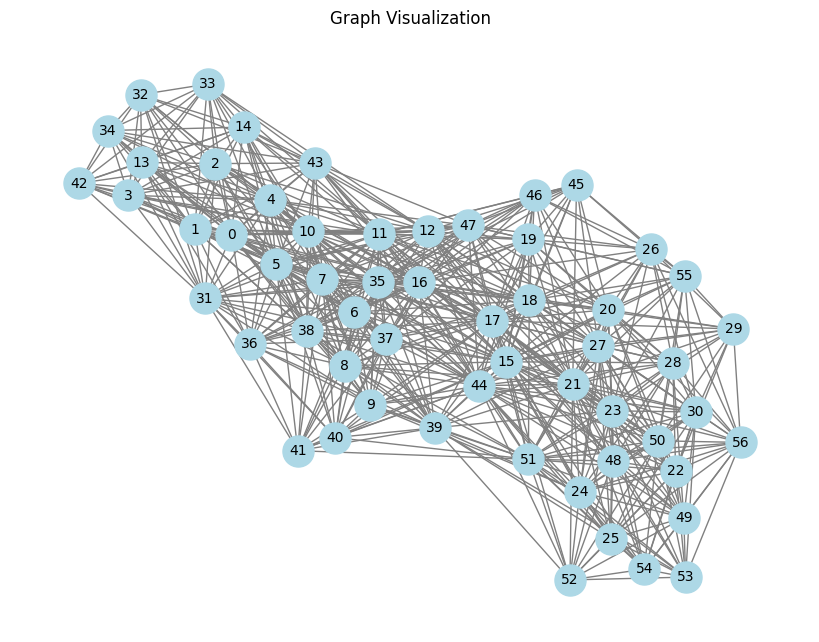

In [13]:
# Visualize graph
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx

def visualize_graph(data):
    """
    Visualizes a PyTorch Geometric graph using NetworkX and Matplotlib.
    
    Args:
    - data (torch_geometric.data.Data): The graph data object to visualize.
    """
    # Convert PyTorch Geometric data to NetworkX graph
    G = to_networkx(data, to_undirected=True)
    
    # Draw the graph
    plt.figure(figsize=(8, 6))
    nx.draw(G, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    plt.title("Graph Visualization")
    plt.show()

# Example: Visualize the first graph in the dataset
sample_graph = train_graphs[0]  # Replace with the desired graph from your dataset
visualize_graph(sample_graph)


In [8]:
train_graphs[0]

Data(x=[57, 1], edge_index=[2, 1274], edge_attr=[1274, 1], y=[57])

## Design GNN Model

In [14]:
# Model definition
# Define the GNN model using GINConv (Graph Isomorphism Network)
class GNNModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, dropout=0.5):
        super(GNNModel, self).__init__()

        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            input_dim = in_channels if i == 0 else hidden_channels
            self.convs.append(GINConv(
                Sequential(
                    Linear(input_dim, hidden_channels),
                    ReLU(),
                    Linear(hidden_channels, hidden_channels)
                ),
                train_eps=True
            ))

        # Dropout layer
        self.dropout = Dropout(dropout)

        # Fully connected layer to output final prediction
        self.fc = Linear(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # Apply the GIN layers with dropout
        for conv in self.convs:
            x = conv(x, edge_index)
            x = self.dropout(x)  # Apply dropout after each GIN layer

        # Fully connected layer for predictions
        x = self.fc(x)
        return x

## Train/Validate/Test

In [15]:


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model
in_channels = 1  # Number of input features per node
hidden_channels = 128  # Number of hidden units in GIN layers
out_channels = 1  # Output a single value per node
num_layers = 3  # Number of GIN layers

# Dataloader parameters
batch_size = 256

# Training parameters
num_epochs = 50
lr = 0.005 
weight_decay = 1e-4
dropout = 0.3

# DataLoader
train_loader = DataLoader(train_graphs, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_graphs, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_graphs, batch_size=batch_size, shuffle=False)

model = GNNModel(in_channels, hidden_channels, out_channels, num_layers,dropout=dropout).to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Loss function
criterion = torch.nn.MSELoss()  # Mean squared error for regression tasks

# Training and validation loop
def train():
    """
    Trains the model for one epoch and computes the loss and accuracy.

    Returns:
    - Tuple[float, float]: Training loss and accuracy.
    """
    model.train()
    total_loss = 0
    total_correct = 0
    total_samples = 0

    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        output = model(data)

        # Compute loss
        loss = F.mse_loss(output.squeeze(), data.y)
        total_loss += loss.item() * data.num_graphs

        # Compute accuracy       
        predictions = output.squeeze()
        correct = torch.sum(torch.abs(predictions - data.y) < 0.1)  # Example threshold: 0.1
        total_correct += correct.item()
        total_samples += data.y.size(0)

        loss.backward()
        optimizer.step()

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy


def validate(loader, test=False):
    """
    Validates the model and computes the loss and accuracy.

    Args:
    - loader (DataLoader): Validation or test DataLoader.

    Returns:
    - Tuple[float, float]: Validation loss and accuracy.
    """
    model.eval()
    total_loss = 0
    total_correct = 0 # correct predictions
    total_samples = 0 # sample count

    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            output = model(data)

            # Compute loss
            loss = F.mse_loss(output.squeeze(), data.y)
            total_loss += loss.item() * data.num_graphs

            # Compute accuracy
            predictions = output.squeeze()
            if (test == True):
                 print(f"\nprediction: {predictions} Actual: {data.y} ")
            correct = torch.sum(torch.abs(predictions - data.y) < 0.1)  # Example threshold: 0.1
            total_correct += correct.item()
            total_samples += data.y.size(0)

    avg_loss = total_loss / total_samples
    accuracy = total_correct / total_samples
    return avg_loss, accuracy

# Training process
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train()
    valid_loss, valid_acc = validate(valid_loader)
    print(f"Epoch {epoch}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4%}, "
          f"Valid Loss: {valid_loss:.4f}, Valid Acc: {valid_acc:.4%}")

# Test the model after training
test_loss, test_acc = validate(test_loader, True)
print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4%}")


Epoch 1, Train Loss: 211.0386, Train Acc: 1.4020%, Valid Loss: 0.0026, Valid Acc: 0.0000%
Epoch 2, Train Loss: 0.0067, Train Acc: 0.6016%, Valid Loss: 0.0026, Valid Acc: 0.0000%
Epoch 3, Train Loss: 0.0029, Train Acc: 0.2214%, Valid Loss: 0.0025, Valid Acc: 0.0000%
Epoch 4, Train Loss: 0.0028, Train Acc: 0.1956%, Valid Loss: 0.0025, Valid Acc: 0.0000%
Epoch 5, Train Loss: 0.0026, Train Acc: 0.1301%, Valid Loss: 0.0023, Valid Acc: 0.0000%
Epoch 6, Train Loss: 0.0025, Train Acc: 0.1370%, Valid Loss: 0.0022, Valid Acc: 0.0059%
Epoch 7, Train Loss: 0.0024, Train Acc: 0.1130%, Valid Loss: 0.0021, Valid Acc: 0.0059%
Epoch 8, Train Loss: 0.0022, Train Acc: 0.1370%, Valid Loss: 0.0020, Valid Acc: 0.0059%
Epoch 9, Train Loss: 0.0021, Train Acc: 0.2058%, Valid Loss: 0.0019, Valid Acc: 0.0059%
Epoch 10, Train Loss: 0.0020, Train Acc: 0.6800%, Valid Loss: 0.0018, Valid Acc: 0.0059%
Epoch 11, Train Loss: 0.0018, Train Acc: 2.8608%, Valid Loss: 0.0017, Valid Acc: 0.0059%
Epoch 12, Train Loss: 0.0017

# Inference

In [20]:
def predict_sample(sample, correct_value):
    """
    Predicts the output for a single sample and compares it with the correct value.

    Args:
    - sample (dict): Graph sample in the format accepted by the `create_graph` function.
    - correct_value (array-like or tensor): Correct target value(s) for the sample.

    Returns:
    - Tuple[float, float]: Predicted value and correct value.
    """
    ## Create a PyTorch Geometric Data object for the sample
    #graph = create_graph(sample, correct_value).to(device)
    
    # Put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        # Generate prediction
        output = model(sample)
    
    # Aggregate predictions if the model outputs multiple values
    predicted_value = output.mean().cpu().item()  # Take the mean of all node predictions
    correct_value = correct_value.mean()  # Take the mean of all node targets

    # Handle correct_value to ensure it is a scalar
    if isinstance(correct_value, (list, np.ndarray)):
        correct_value = correct_value[0]  # Take the first value if it's a list or array
    elif isinstance(correct_value, torch.Tensor):
        correct_value = correct_value.squeeze().cpu().item()  # Convert single-element tensor to scalar
    
    return predicted_value, correct_value


# Example: Use the first sample from the test dataset
sample_num = 0
sample = test_graphs[sample_num]
correct_value = test_graphs[sample_num].y  # Assuming y_test is a list of values

predicted, actual = predict_sample(sample, correct_value)
print(f"Predicted Value: {predicted:.4f}, Actual Value: {actual:.4f}")



Predicted Value: 0.2666, Actual Value: 0.2734
